In [1]:
# corrigir erro do K-Means
!pip install -q threadpoolctl==3.1.0

In [2]:
import threadpoolctl
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

In [49]:
df = pd.read_csv("dataset.csv")

In [50]:
df.head()

Idade  Gasto_Mensal  Tempo_de_Assinatura  Taxa_de_Uso  Suporte_Tickets  \
0     48    529.152948                   13     0.524262                2   
1     37    684.502168                   13     0.628494                2   
2     31    797.016155                   17     0.706550                1   
3     30    542.025205                   12     0.517458                3   
4     44    655.498896                   15     0.774564                3   

   Cancelou  
0         1  
1         0  
2         0  
3         0  
4         0

In [51]:
# checando valores nulos
df.isnull().sum()

Idade                  0
Gasto_Mensal           0
Tempo_de_Assinatura    0
Taxa_de_Uso            0
Suporte_Tickets        0
Cancelou               0
dtype: int64

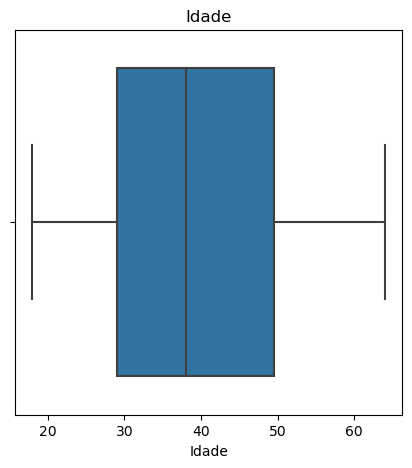

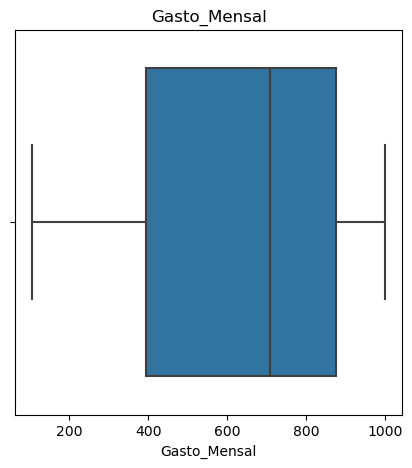

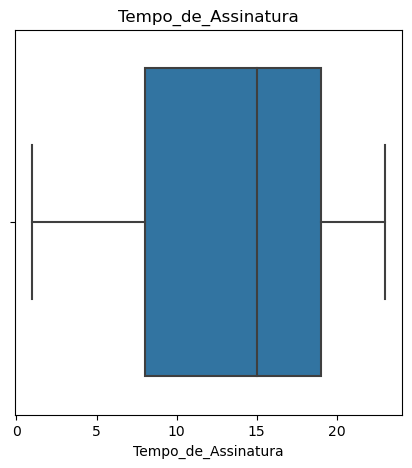

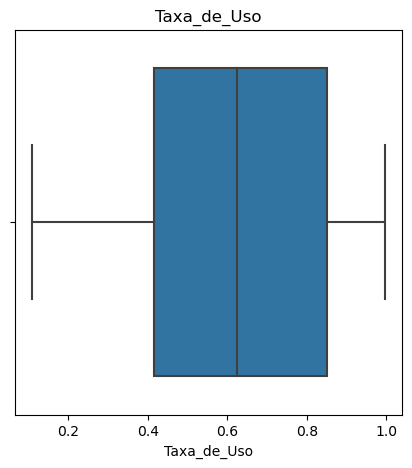

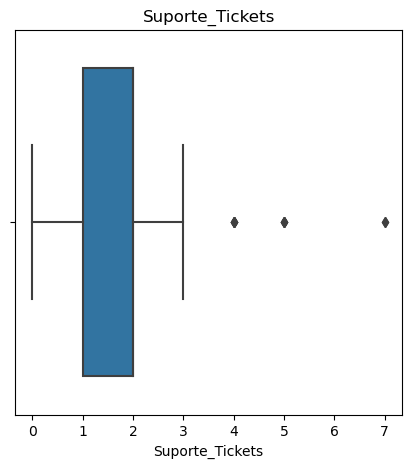

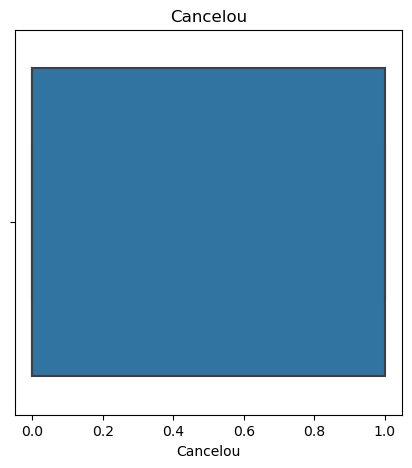

In [52]:
# visualizando outliers para cada variável do DF
for column in df.columns:
    if df[column].dtype in ['int64', 'float64']:  
        plt.figure(figsize = (5, 5))
        sns.boxplot(x = df[column])
        plt.title(column)
        plt.show()

In [53]:
df.describe()

Idade  Gasto_Mensal  Tempo_de_Assinatura  Taxa_de_Uso  \
count  99.000000     99.000000            99.000000    99.000000   
mean   39.888889    639.071009            13.646465     0.604374   
std    13.089869    270.618268             6.599804     0.263824   
min    18.000000    106.254563             1.000000     0.110168   
25%    29.000000    394.918421             8.000000     0.414928   
50%    38.000000    709.104722            15.000000     0.623406   
75%    49.500000    875.735422            19.000000     0.849839   
max    64.000000    999.943535            23.000000     0.996007   

       Suporte_Tickets   Cancelou  
count        99.000000  99.000000  
mean          1.747475   0.494949  
std           1.486974   0.502519  
min           0.000000   0.000000  
25%           1.000000   0.000000  
50%           2.000000   0.000000  
75%           2.000000   1.000000  
max           7.000000   1.000000

In [54]:
df.Cancelou.value_counts()

0    50
1    49
Name: Cancelou, dtype: int64

In [55]:
# Define o Intervalo Interquartil
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Idade                   20.500000
Gasto_Mensal           480.817001
Tempo_de_Assinatura     11.000000
Taxa_de_Uso              0.434911
Suporte_Tickets          1.000000
Cancelou                 1.000000
dtype: float64


In [56]:
outliers = ((df < (Q1 - 2.5 * IQR)) | (df > (Q3 + 2.5 * IQR))).any(axis = 1)

In [57]:
# filtrando os outliers
df_outliers = df[outliers]

In [58]:
df_outliers

Idade  Gasto_Mensal  Tempo_de_Assinatura  Taxa_de_Uso  Suporte_Tickets  \
12     46    743.034018                   16     0.697133                5   
53     48    550.847824                   12     0.619646                7   
54     43    667.040379                   13     0.630056                5   
63     34    694.989179                   17     0.536049                7   
95     53    999.943535                   23     0.865750                5   
96     48    999.327367                   21     0.926680                5   

    Cancelou  
12         0  
53         1  
54         0  
63         1  
95         1  
96         1

In [59]:
# Calculando a matriz de correlação
matriz_correlacao = df.corr()

In [60]:
matriz_correlacao

Idade  Gasto_Mensal  Tempo_de_Assinatura  Taxa_de_Uso  \
Idade                1.000000      0.856041             0.814066     0.846363   
Gasto_Mensal         0.856041      1.000000             0.914275     0.912730   
Tempo_de_Assinatura  0.814066      0.914275             1.000000     0.891799   
Taxa_de_Uso          0.846363      0.912730             0.891799     1.000000   
Suporte_Tickets      0.431047      0.378802             0.427516     0.380526   
Cancelou             0.624298      0.651229             0.687107     0.643879   

                     Suporte_Tickets  Cancelou  
Idade                       0.431047  0.624298  
Gasto_Mensal                0.378802  0.651229  
Tempo_de_Assinatura         0.427516  0.687107  
Taxa_de_Uso                 0.380526  0.643879  
Suporte_Tickets             1.000000  0.278220  
Cancelou                    0.278220  1.000000

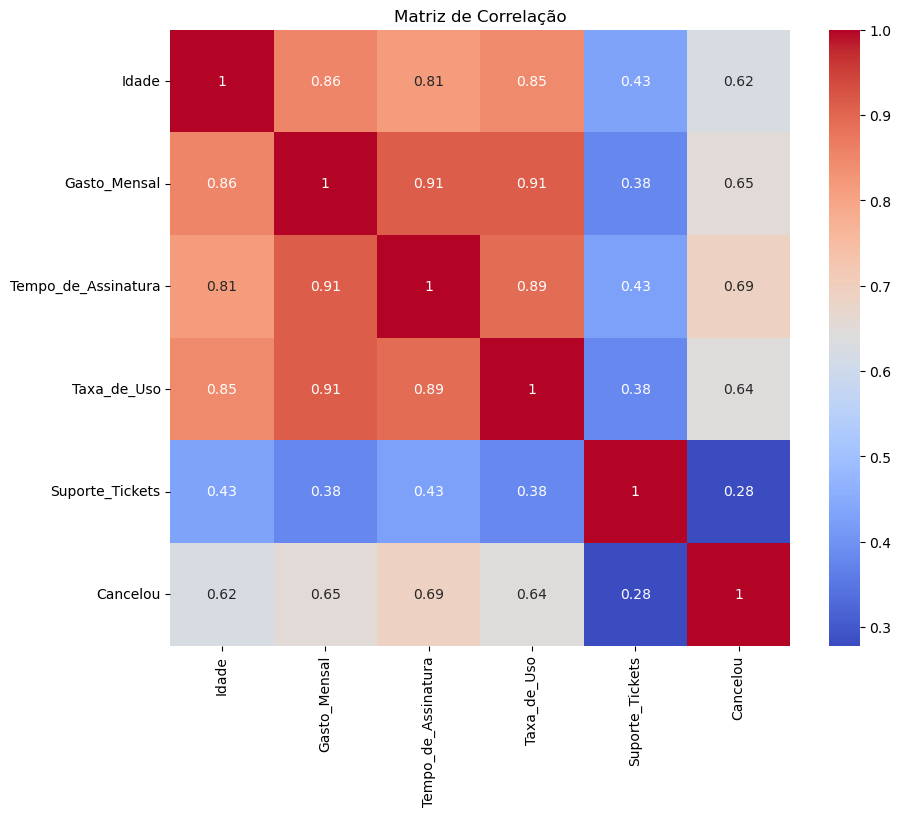

In [61]:
# heatmap da matriz de correlacao
plt.figure(figsize = (10,8))
sns.heatmap(matriz_correlacao, annot = True, cmap = 'coolwarm')
plt.title('Matriz de Correlação')
plt.show()

In [62]:
# Cria o padronizador, dado que o algoritmo k-means exige que 
# todos os dados estejam na mesma escala
scaler = StandardScaler()

In [63]:
# Padronizando as Variáveis
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)

In [64]:
df_scaled.head()

Idade  Gasto_Mensal  Tempo_de_Assinatura  Taxa_de_Uso  Suporte_Tickets  \
0  0.622801     -0.408241            -0.098451    -0.305201         0.170689   
1 -0.221820      0.168733            -0.098451     0.091893         0.170689   
2 -0.682522      0.586616             0.510712     0.389261        -0.505240   
3 -0.759306     -0.360433            -0.250741    -0.331122         0.846619   
4  0.315666      0.061014             0.206131     0.648375         0.846619   

   Cancelou  
0  1.010153  
1 -0.989949  
2 -0.989949  
3 -0.989949  
4 -0.989949

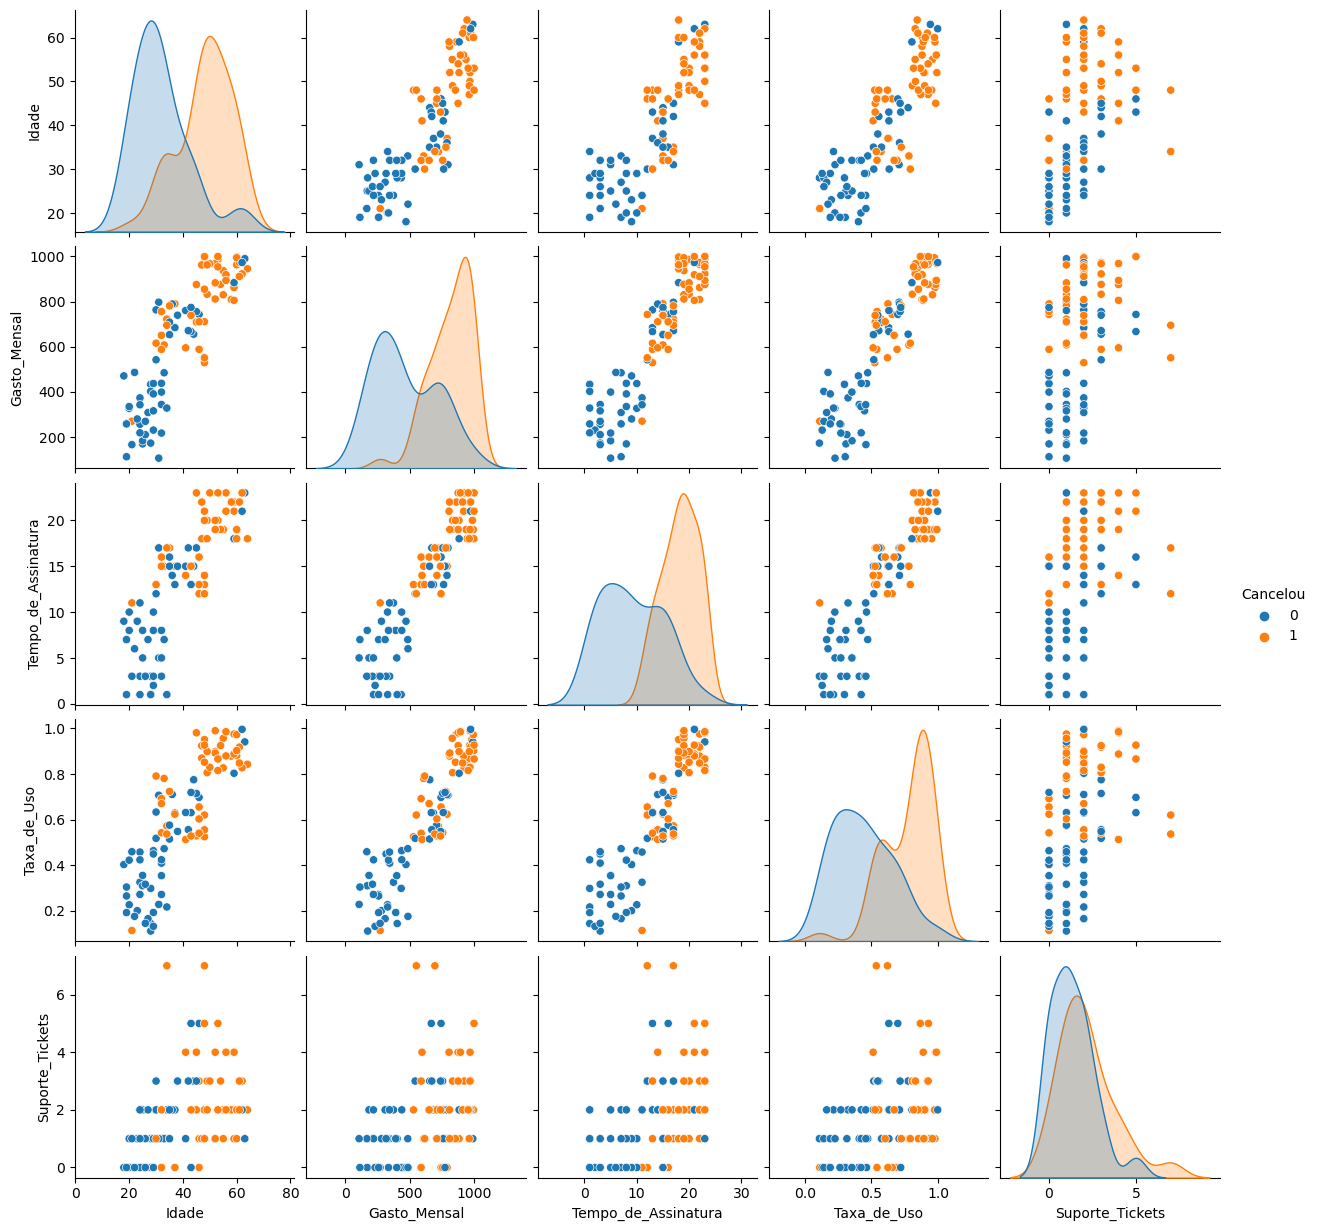

In [65]:
# Visualização de Dados com PairPlot
sns.pairplot(df, hue = 'Cancelou', diag_kind = 'kde')
plt.show()

In [66]:
# Lista para armazenar o SSE
sse = []
# Range de valores de k a serem testados
k_range = range(1, 11)

In [67]:
# definindo os valores de k para os testes
for k in k_range:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(df_scaled)
    sse.append(kmeans.inertia_)

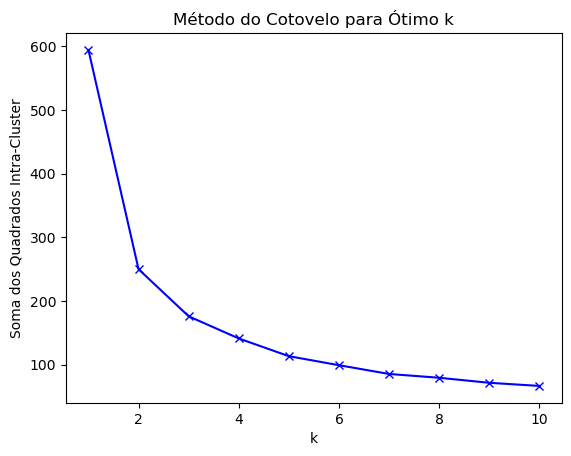

In [68]:
# Plot
plt.plot(k_range, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('Soma dos Quadrados Intra-Cluster')
plt.title('Método do Cotovelo para Ótimo k')
plt.show()

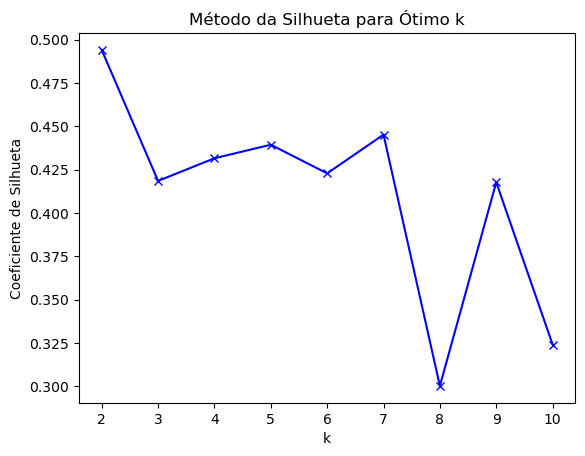

In [69]:
# lista para o Silhouette score
sil_score = []

# loop pelo range de valores de k a serem testados
for k in k_range:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(df_scaled)
    
    # silhouette score não é definido para k = 1, então filtraremos
    if k != 1:
        sil_score.append(silhouette_score(df_scaled, kmeans.labels_))

# Plot
plt.plot(k_range[1:], sil_score, 'bx-')
plt.xlabel('k')
plt.ylabel('Coeficiente de Silhueta')
plt.title('Método da Silhueta para Ótimo k')
plt.show()

In [70]:
# criando o modelo com 4 clusters
modelo_kmeans = KMeans(n_clusters = 4, random_state = 42)

In [71]:
# Treinando o modelo e salvando o resultado em uma coluna do dataset original
df['cluster'] = modelo_kmeans.fit_predict(df_scaled)

In [72]:
# Amostra aleatória de dados
df.sample(10)

Idade  Gasto_Mensal  Tempo_de_Assinatura  Taxa_de_Uso  Suporte_Tickets  \
76     53    986.545697                   20     0.870118                2   
80     45    875.292673                   23     0.980832                4   
27     18    470.663546                    9     0.402220                0   
57     42    671.018351                   17     0.555300                3   
13     24    373.305408                   11     0.324511                2   
10     32    588.077553                   16     0.691481                0   
88     50    967.665741                   23     0.829415                3   
47     36    789.085993                   14     0.709854                2   
81     47    962.110666                   18     0.869651                1   
73     64    945.143902                   18     0.842593                2   

    Cancelou  cluster  
76         1        1  
80         1        1  
27         0        0  
57         0        2  
13         0        0  
10         1        3  
88         1        1  
47         0        2  
81         1        1  
73         1        1

In [73]:
# foi usado o dataset original, incluindo os outliers
df_cleaned = df

In [74]:
# Criando um mapa de cores baseado na paleta 'Dark2'
palette = sns.color_palette('Dark2', n_colors = len(df_cleaned['cluster'].unique()))
color_map = dict(zip(df_cleaned['cluster'].unique(), palette))

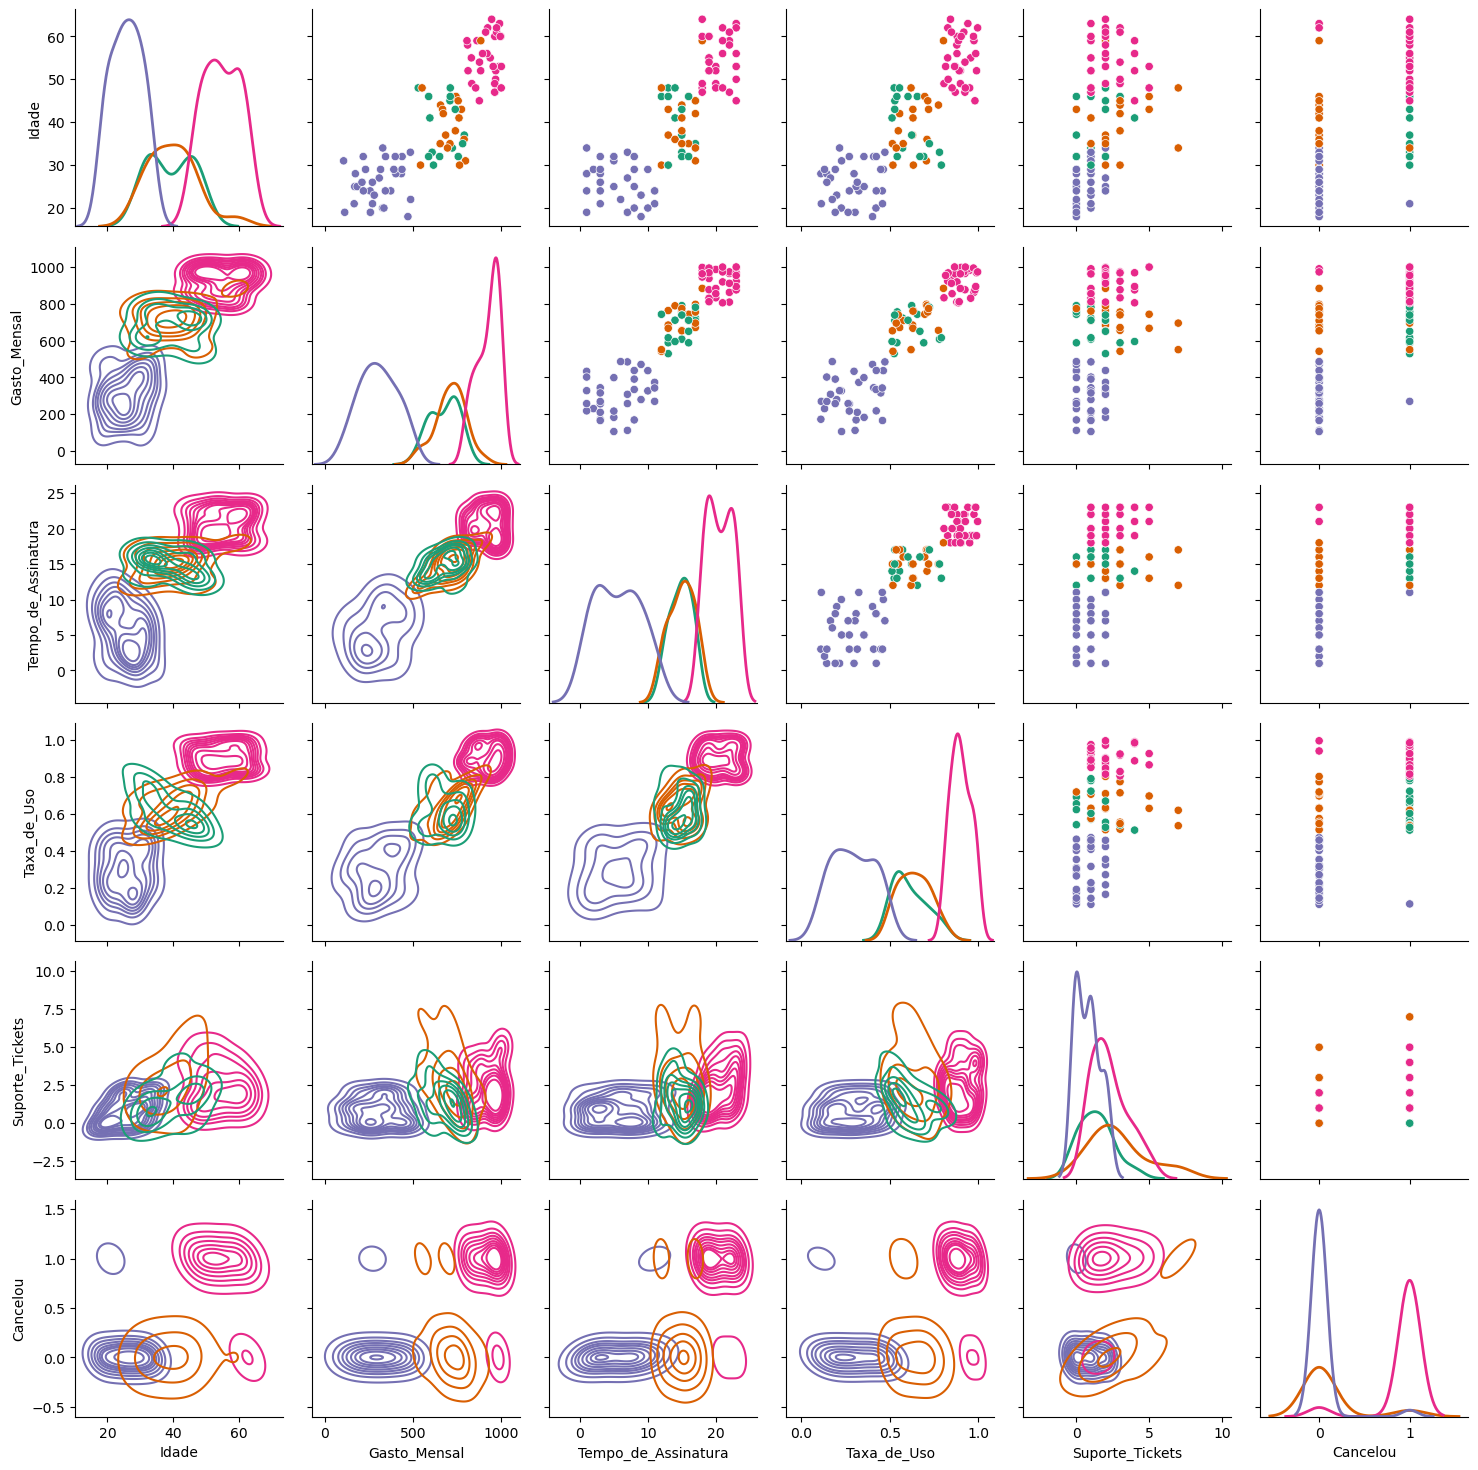

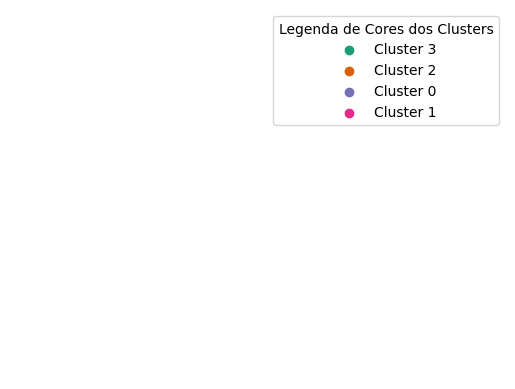

In [75]:
# Plotando o gráfico de grid com os clusters e mostrando o mapa de cores
g = sns.PairGrid(df_cleaned, hue = 'cluster', palette = color_map, diag_sharey = False)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw = 2)
plt.show()

# legenda do mapa de cores
for cluster, color in color_map.items():
    plt.scatter([], [], c = [color], label = f'Cluster {cluster}')
plt.legend(title = 'Legenda de Cores dos Clusters')
plt.axis('off')
plt.show()

In [76]:
# Modelo com 3 clusters, tirando os outliers
modelo_kmeans_3c = KMeans(n_clusters = 3, random_state = 42)

In [77]:
df.drop('cluster', axis = 1, inplace = True)

In [79]:
# Treina o modelo e salva o resultado em uma coluna do dataframe original
df['cluster'] = modelo_kmeans_3c.fit_predict(df_scaled)

In [80]:
# Mantém apenas as linhas que não são outliers
df_cleaned2 = df[~outliers]

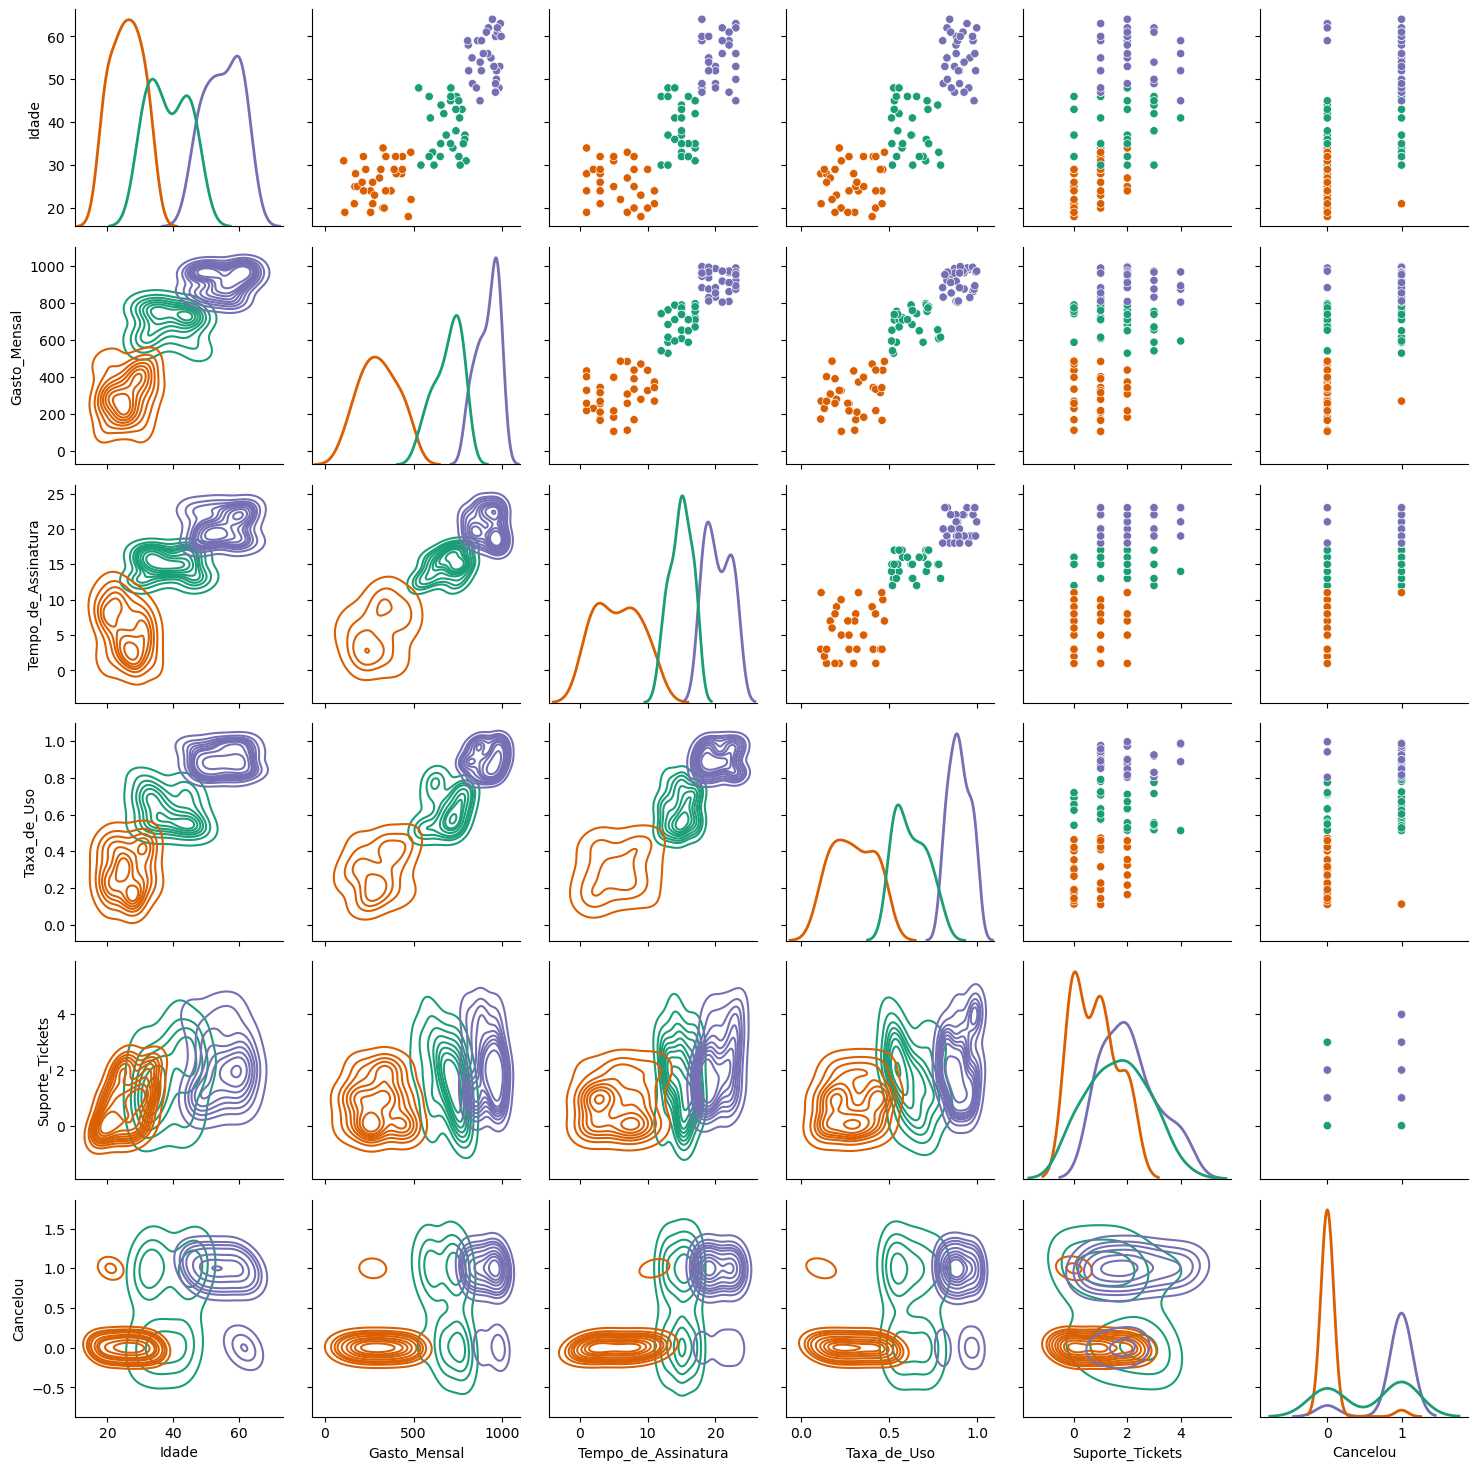

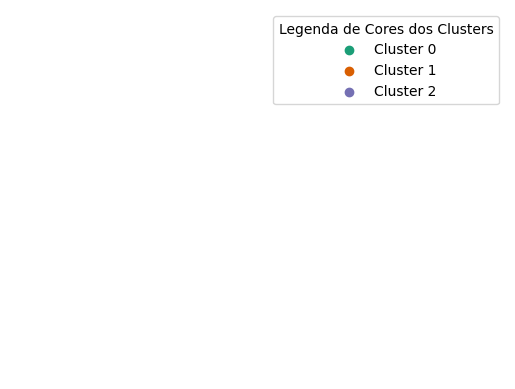

In [81]:
# Criando um mapa de cores baseado na paleta 'Dark2'
palette = sns.color_palette('Dark2', n_colors = len(df_cleaned2['cluster'].unique()))
color_map = dict(zip(df_cleaned2['cluster'].unique(), palette))

# Plotando o gráfico de grid com os clusters e mostrando o mapa de cores
g = sns.PairGrid(df_cleaned2, hue = 'cluster', palette = color_map, diag_sharey = False)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw = 2)
plt.show()

# Mostrando o mapa de cores
for cluster, color in color_map.items():
    plt.scatter([], [], c = [color], label = f'Cluster {cluster}')
plt.legend(title = 'Legenda de Cores dos Clusters')
plt.axis('off')
plt.show()

In [92]:
# Modelo com 3 clusters, tirando os outliers
modelo_kmeans_4c = KMeans(n_clusters = 4, random_state = 42)

In [93]:
df.drop('cluster', axis = 1, inplace = True)

In [94]:
# Treina o modelo e salva o resultado em uma coluna do dataframe original
df['cluster'] = modelo_kmeans_4c.fit_predict(df_scaled)

In [95]:
# Mantém apenas as linhas que não são outliers
df_cleaned3 = df[~outliers]

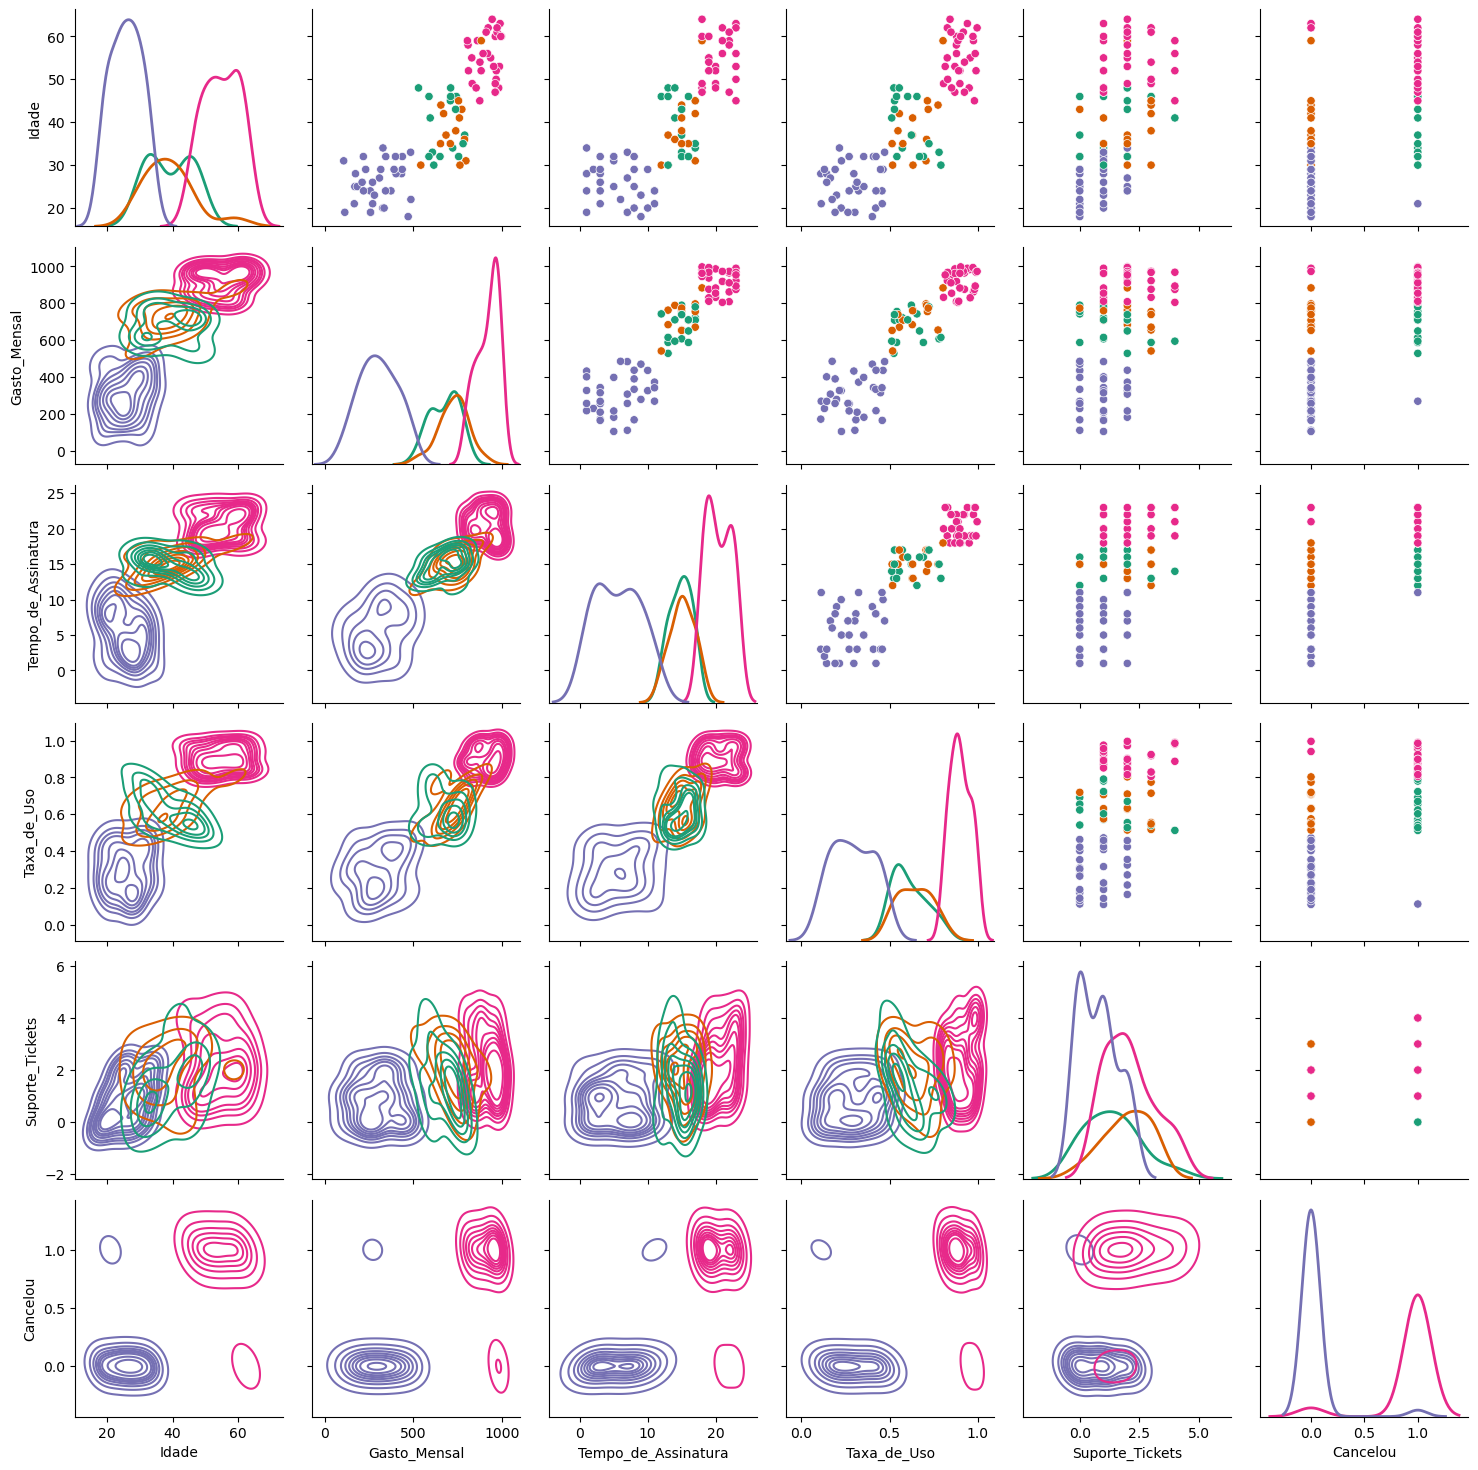

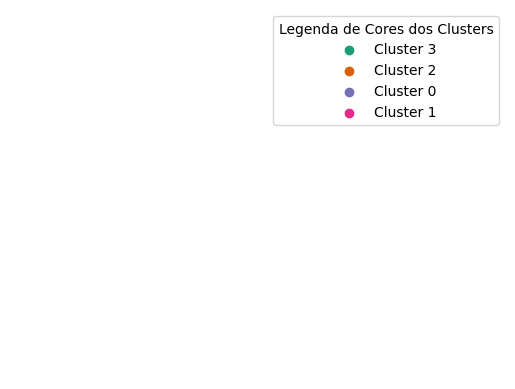

In [96]:
# Criando um mapa de cores baseado na paleta 'Dark2'
palette = sns.color_palette('Dark2', n_colors = len(df_cleaned3['cluster'].unique()))
color_map = dict(zip(df_cleaned3['cluster'].unique(), palette))

# Plotando o gráfico de grid com os clusters e mostrando o mapa de cores
g = sns.PairGrid(df_cleaned3, hue = 'cluster', palette = color_map, diag_sharey = False)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw = 2)
plt.show()

# Mostrando o mapa de cores
for cluster, color in color_map.items():
    plt.scatter([], [], c = [color], label = f'Cluster {cluster}')
plt.legend(title = 'Legenda de Cores dos Clusters')
plt.axis('off')
plt.show()

In [106]:
# extraindo os centróides
centroides = modelo_kmeans.cluster_centers_
centroides

array([[-1.07807472, -1.24869086, -1.22447918, -1.1858289 , -0.64861907,
        -0.92934034],
       [ 1.13869219,  1.06253958,  1.05324823,  1.12759411,  0.36079436,
         0.88514617],
       [-0.00426576,  0.27438054,  0.20613092,  0.13402826,  0.77151531,
        -0.76771593],
       [-0.04905628,  0.14166762,  0.18709457,  0.03980211, -0.25176661,
         1.01015254]])

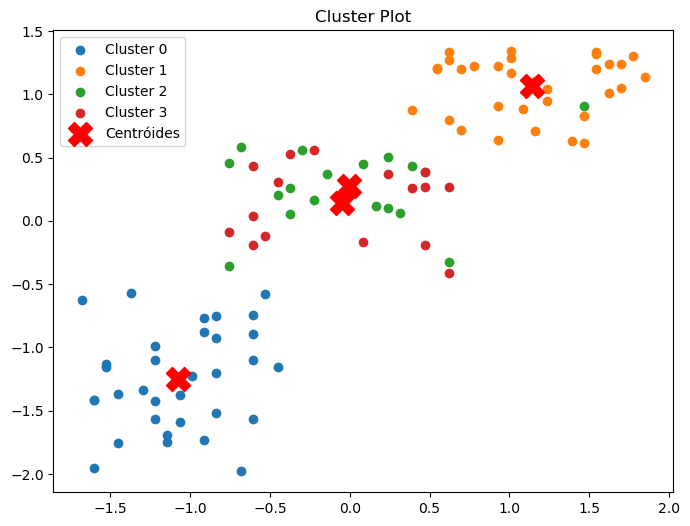

In [107]:
# visualizando 
# Cria a figura
plt.figure(figsize = (8, 6))

# Loop pelos clusters
for cluster_num in range(4):
    mask = df['cluster'] == cluster_num
    plt.scatter(df_scaled[mask].iloc[:, 0], df_scaled[mask].iloc[:, 1], label = f'Cluster {cluster_num}')

# Plot
plt.scatter(modelo_kmeans.cluster_centers_[:, 0], 
            modelo_kmeans.cluster_centers_[:, 1], 
            s = 300, 
            c = 'red', 
            marker = 'X', 
            label = 'Centróides')
plt.legend()
plt.title("Cluster Plot")
plt.show()

In [108]:
df['cluster'].value_counts()

0    33
1    32
2    18
3    16
Name: cluster, dtype: int64

In [109]:
# extraindo os centróides - tres clusters (sem outliers)
centroides2 = modelo_kmeans_3c.cluster_centers_
centroides2

array([[-0.07057899,  0.19082299,  0.18305656,  0.06948432,  0.29358547,
         0.10101525],
       [-1.07807472, -1.24869086, -1.22447918, -1.1858289 , -0.64861907,
        -0.92934034],
       [ 1.14865372,  1.05786786,  1.04142262,  1.11634458,  0.35503359,
         0.82832509]])

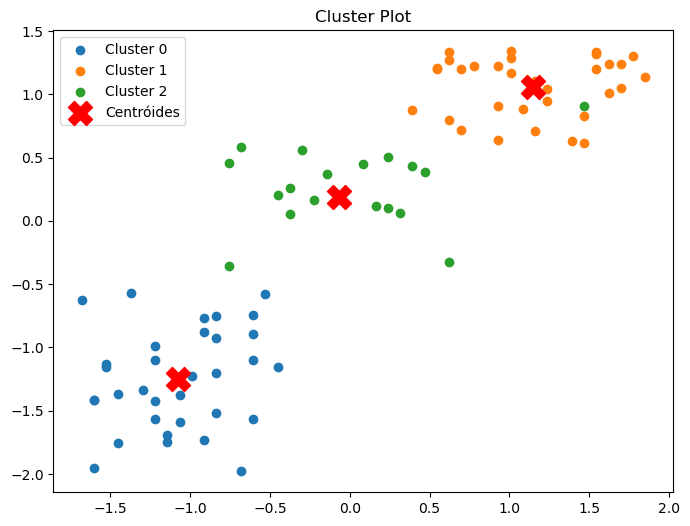

In [113]:
# visualizando 
# Cria a figura
plt.figure(figsize = (8, 6))

# Loop pelos clusters
for cluster_num in range(3):
    mask = df['cluster'] == cluster_num
    plt.scatter(df_scaled[mask].iloc[:, 0], df_scaled[mask].iloc[:, 1], label = f'Cluster {cluster_num}')

# Plot
plt.scatter(modelo_kmeans_3c.cluster_centers_[:, 0], 
            modelo_kmeans_3c.cluster_centers_[:, 1], 
            s = 300, 
            c = 'red', 
            marker = 'X', 
            label = 'Centróides')
plt.legend()
plt.title("Cluster Plot")
plt.show()

In [104]:
# extraindo os centróides - quatro clusters (sem outliers)
centroides3 = modelo_kmeans_4c.cluster_centers_
centroides3

array([[-1.07807472, -1.24869086, -1.22447918, -1.1858289 , -0.64861907,
        -0.92934034],
       [ 1.13869219,  1.06253958,  1.05324823,  1.12759411,  0.36079436,
         0.88514617],
       [-0.00426576,  0.27438054,  0.20613092,  0.13402826,  0.77151531,
        -0.76771593],
       [-0.04905628,  0.14166762,  0.18709457,  0.03980211, -0.25176661,
         1.01015254]])

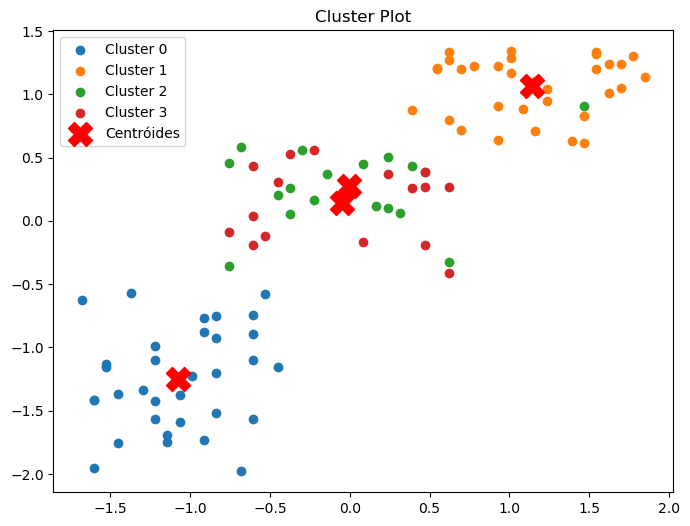

In [117]:
# visualizando 
# Cria a figura
plt.figure(figsize = (8, 6))

# Loop pelos clusters
for cluster_num in range(4):
    mask = df['cluster'] == cluster_num
    plt.scatter(df_scaled[mask].iloc[:, 0], df_scaled[mask].iloc[:, 1], label = f'Cluster {cluster_num}')

# Plot
plt.scatter(modelo_kmeans_4c.cluster_centers_[:, 0], 
            modelo_kmeans_4c.cluster_centers_[:, 1], 
            s = 300, 
            c = 'red', 
            marker = 'X', 
            label = 'Centróides')
plt.legend()
plt.title("Cluster Plot")
plt.show()

In [120]:
score = silhouette_score(df_scaled, df['cluster'])
print(score)

0.4409848855929258


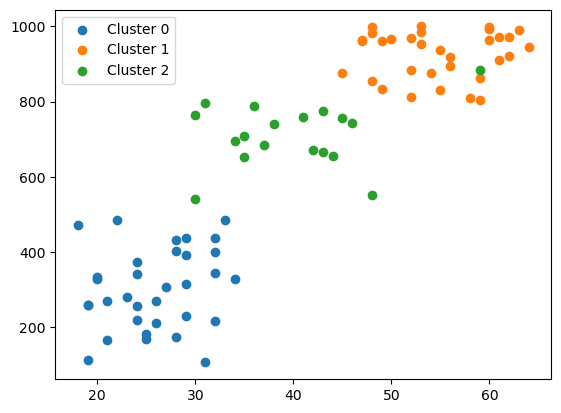

In [121]:
# Plot
plt.scatter(df[df['cluster'] == 0]['Idade'], df[df['cluster'] == 0]['Gasto_Mensal'], label='Cluster 0')
plt.scatter(df[df['cluster'] == 1]['Idade'], df[df['cluster'] == 1]['Gasto_Mensal'], label='Cluster 1')
plt.scatter(df[df['cluster'] == 2]['Idade'], df[df['cluster'] == 2]['Gasto_Mensal'], label='Cluster 2')
plt.legend()
plt.show()

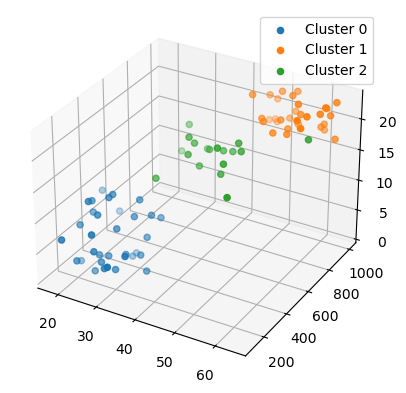

In [122]:
# Plot 3D
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df[df['cluster'] == 0]['Idade'], df[df['cluster'] == 0]['Gasto_Mensal'], df[df['cluster'] == 0]['Tempo_de_Assinatura'], label='Cluster 0')
ax.scatter(df[df['cluster'] == 1]['Idade'], df[df['cluster'] == 1]['Gasto_Mensal'], df[df['cluster'] == 1]['Tempo_de_Assinatura'], label='Cluster 1')
ax.scatter(df[df['cluster'] == 2]['Idade'], df[df['cluster'] == 2]['Gasto_Mensal'], df[df['cluster'] == 2]['Tempo_de_Assinatura'], label='Cluster 2')

ax.legend()
plt.show()

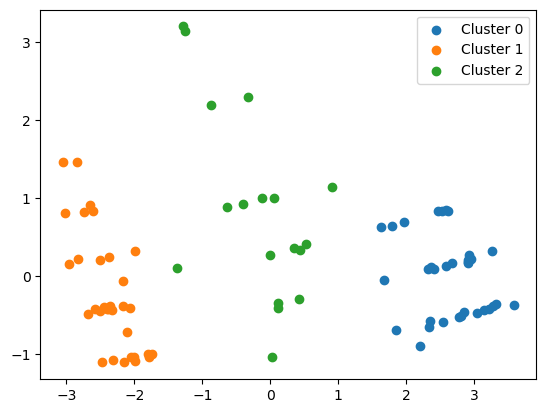

In [124]:
# Visualização com PCA
from sklearn.decomposition import PCA

# Cria o modelo PCA com 2 componentes principais
pca = PCA(n_components = 2)

# Treina o modelo usando dados padronizados
principalComponents = pca.fit_transform(df_scaled)

# Cria o dataframe com o resultado
df_principal = pd.DataFrame(data = principalComponents, columns = ['PC 1', 'PC 2'])
df_principal['cluster'] = df['cluster']

# Cria o gráfico
plt.scatter(df_principal[df_principal['cluster'] == 0]['PC 1'], df_principal[df_principal['cluster'] == 0]['PC 2'], label='Cluster 0')
plt.scatter(df_principal[df_principal['cluster'] == 1]['PC 1'], df_principal[df_principal['cluster'] == 1]['PC 2'], label='Cluster 1')
plt.scatter(df_principal[df_principal['cluster'] == 2]['PC 1'], df_principal[df_principal['cluster'] == 2]['PC 2'], label='Cluster 2')
plt.legend()
plt.show()